# Лабораторна робота 7

В Лекції 5, _Виявлення аномалій: методи на основі близькості_, ми розглянули способи позначення аномалій за допомогою різноманітних методів на основі відстані. Зокрема, ми розглянули використання таких методів:
- методи на основі відстані: аномалії - це точки, "далекі" від інших точок
- методи кластеризації: аномалії - це точки, які знаходяться на краях свого кластера / не належать кластеру
- методи на основі щільності: аномалії - це точки з меншою кількістю сусідів, ніж типові точки в тій самій області
- метод DBSCAN для виявлення аномалії - точки, які не входять до жодного кластера, тобто ті, що мають мало сусідів.

# Результати навчання

Ви повинні вийти з цього блокнота зі здатністю
1. Зробіть детектор аномалії kNN (на основі відстані)
2. Створіть детектор аномалії k-середніх (на основі кластера)
3. Використовуйте коефіцієнт локального викиду для класифікації аномалій
4. Застосуйте Density-Based Spatial Clustering of Applications with Noise


# Імпорт

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import sklearn.datasets as sk_data
import sklearn.neighbors as neighbors
import sys

np.set_printoptions(suppress=True, precision=4)

## Розділ 1: Методи на основі відстані

 Найпростіший метод найближчого сусіда (NN) полягає в тому, щоб прийняти відстань до k-найближчого сусіда як показник аномалії. Наступним варіантом є використання середнього значення відстаней до перших k сусідів як оцінка. `sklearn` надає `neighbors.NearestNeighbors` для обчислення найближчих сусідів із набору даних. Після підгонки ми можемо використовувати `kneighbors()`, щоб повернути відстані та індекси верхніх k сусідів. Ми можемо використати `kneighbors_graph()`, щоб повернути весь графік зв’язності (як масив, де 1 вказує на посилання) для набору даних. Граф — це розріджений масив, але з ним можна працювати так само, як і зі звичайним (щільним) масивом. Якщо вам потрібен звичайний масив, ви можете використовувати `todense()`, щоб зробити його щільним.

Ідея для моделей kNN така
- подивіться на $k$ сусідів кожної точки
- виставити оцінку. Приблизно, низька оцінка означає, що $k$ сусіди точки близькі.
- існує кілька способів визначення оцінок:
     - максимальна відстань (тобто відстань до $k$-го найближчого сусіда)
     - середнє $k$ відстаней
     - середнє гармонічне $k$ відстаней.

Використовуйте оцінку, щоб визначити, чи є щось аномалією, використовуючи або _threshold_, або _ranking_.

Ми почнемо зі створення простого набору даних з однією аномалією, а потім побудуємо графік даних.

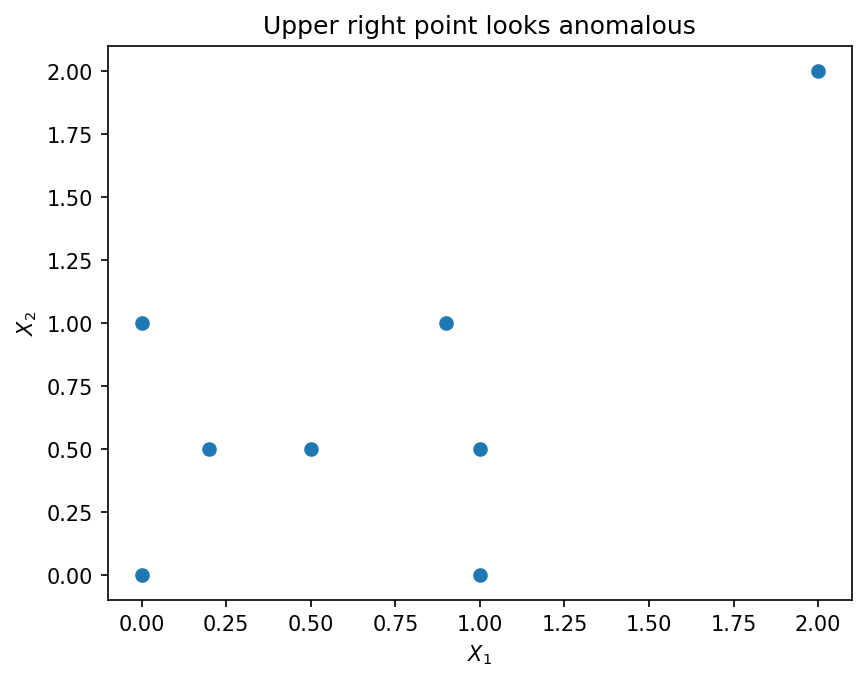

In [2]:
X = np.array([[0.9, 1], [0, 1], [1, 0], [0, 0], [0.5, 0.5], [0.2, 0.5], [1, 0.5], [2, 2]])

plt.figure(dpi=150)
plt.title('Upper right point looks anomalous')
plt.xlabel('$X_1$')
plt.ylabel('$X_2$')
plt.plot(X[:, 0], X[:, 1], 'o');

In [3]:
#import sklearn
#print(sklearn.show_versions())

Давайте створимо функцію для більш чіткогї візуалізації точки запиту та її сусідів.

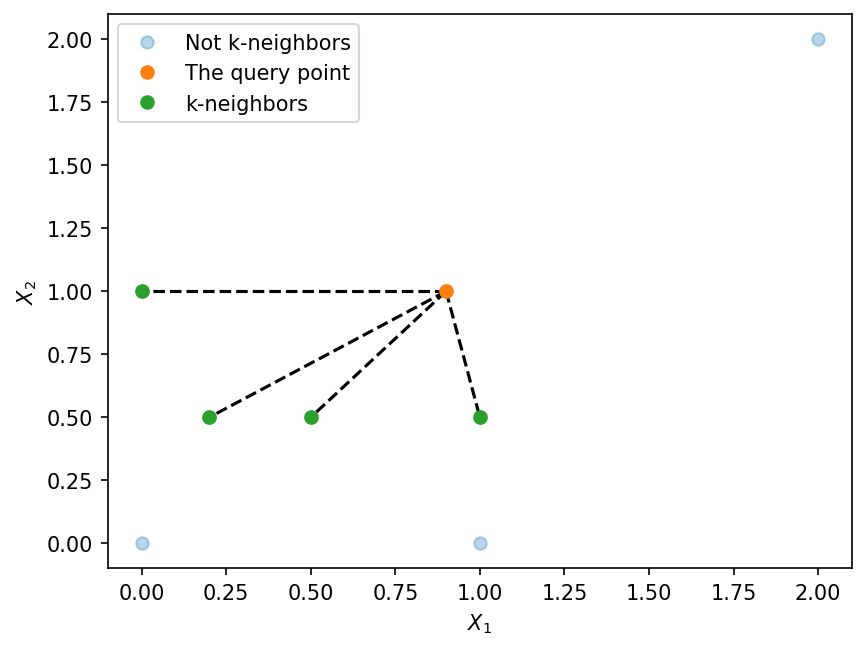

In [4]:
def plot_point_and_k_neighbors(X, highlight_index, n_neighbors=2):  #highlight_index  - індекс точки з вихідних даних
    "Plots the points in X, and shows the n_neighbors of the highlight_index-th point"
    nn = neighbors.NearestNeighbors(n_neighbors=n_neighbors).fit(X) #визначає сусідів
    dist, index = nn.kneighbors()  #дає дистанцію та індекси сусідів для кожної точки
    
    src_pt = X[highlight_index, :]
    
    plt.figure(dpi=150)
    # draw lines first, so points go on top
    for dest_index in index[highlight_index]:
        dest_pt = X[dest_index, :]
        plt.plot(*list(zip(src_pt, dest_pt)), 'k--')
    plt.plot(X[:, 0], X[:, 1], 'o', label='Not k-neighbors', alpha=0.3)
    plt.plot(*src_pt, 'o', label='The query point')
    plt.plot(X[index[highlight_index], 0], X[index[highlight_index], 1], 'o', label='k-neighbors')
    plt.xlabel('$X_1$')
    plt.ylabel('$X_2$')
    plt.legend()
    
# Example of usage
plot_point_and_k_neighbors(X, 0, 4)

Тут ми бачимо, що 4 точки, близькі до точки запиту (індекс 0 у наших даних), відносно близькі. 

Давайте подивимося на аномальну точку вгорі праворуч (ця точка має індекс 7):

In [5]:
aa = neighbors.NearestNeighbors(n_neighbors=4).fit(X) #визначає сусідів
dist, index = aa.kneighbors()
print(dist, index)
print('Координати усіх восьми точок',X)
print('Координати  точки з індексом 7',X[7, :])
print('Індекси сусідніх точок для точки з індексом 7',index[7])
print('Відстані від точки з індексом 7 до сусідніх точок',dist[:,-1])

[[0.5099 0.6403 0.8602 0.9   ]
 [0.5385 0.7071 0.9    1.    ]
 [0.5    0.7071 0.9434 1.    ]
 [0.5385 0.7071 1.     1.    ]
 [0.3    0.5    0.6403 0.7071]
 [0.3    0.5385 0.5385 0.8   ]
 [0.5    0.5    0.5099 0.8   ]
 [1.4866 1.8028 2.1213 2.2361]] [[6 4 5 1]
 [5 4 0 3]
 [6 4 5 3]
 [5 4 1 2]
 [5 6 0 3]
 [4 1 3 6]
 [4 2 0 5]
 [0 6 4 1]]
Координати усіх восьми точок [[0.9 1. ]
 [0.  1. ]
 [1.  0. ]
 [0.  0. ]
 [0.5 0.5]
 [0.2 0.5]
 [1.  0.5]
 [2.  2. ]]
Координати  точки з індексом 7 [2. 2.]
Індекси сусідніх точок для точки з індексом 7 [0 6 4 1]
Відстані від точки з індексом 7 до сусідніх точок [0.9    1.     1.     1.     0.7071 0.8    0.8    2.2361]


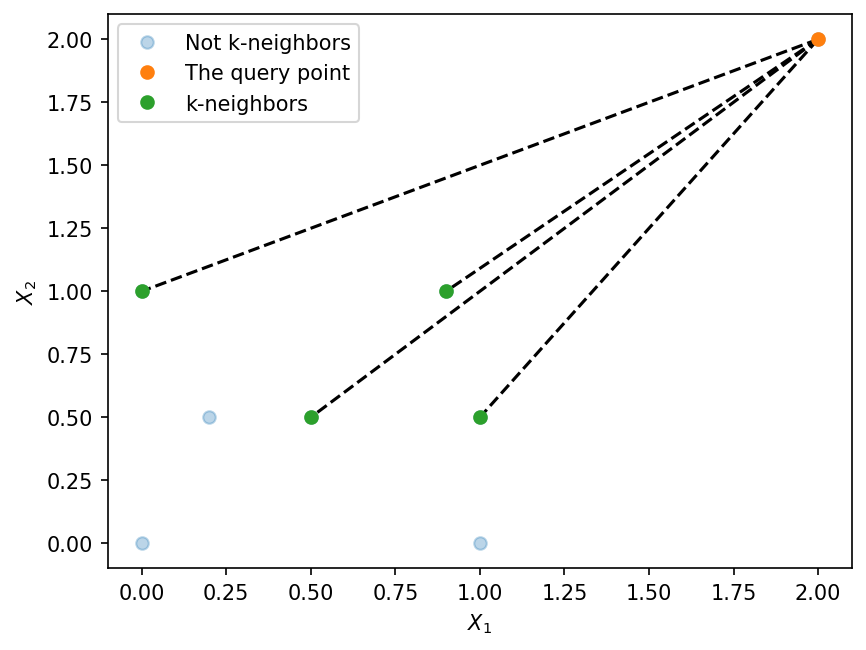

In [6]:
plot_point_and_k_neighbors(X, 7, n_neighbors=4)

У цьому випадку ми бачимо, що всі 4 найближчі сусіди до нашої точки знаходяться далеко, тому здається досить однозначним назвати цю точку аномалією.

Давайте додамо ще одну точку до аномалії та подивимось, як вибір «k» і функція підрахунку оцінок впливають на аналіз.

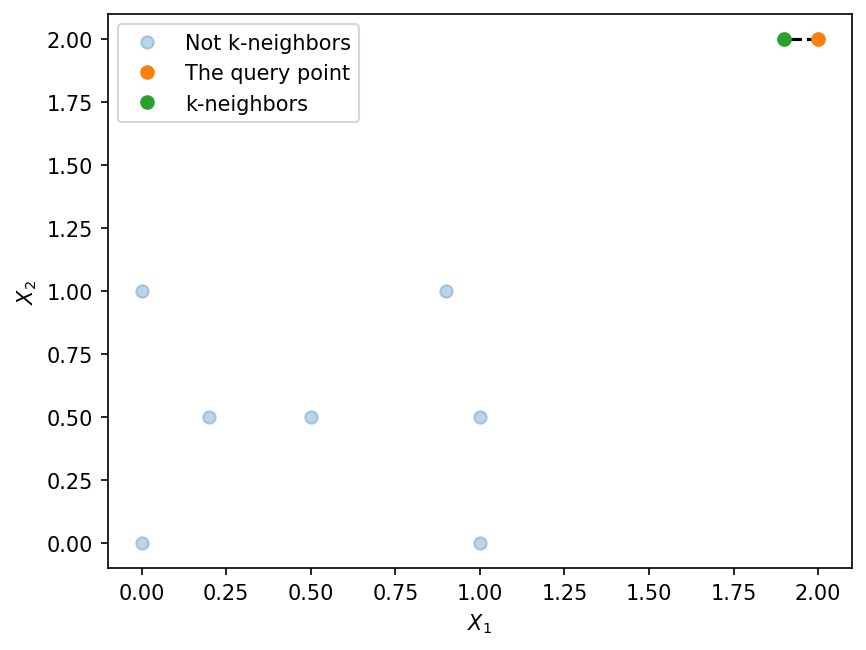

In [7]:
# Набір даних з двома суміжними аномаліями
X2 = np.concatenate([X, [[1.9, 2.0]]])

# Подивіться на найближчого сусіда (k=1)
plot_point_and_k_neighbors(X2, 7, n_neighbors=1)

### Спостереження 1: залежність від $k$

Відстань між точкою 7 і новою точкою насправді досить мала — менша, ніж відстані між будь-якою парою точок у нижньому лівому куті. Якщо $k=1$, дві точки у верхньому правому куті будуть _останніми_, які класифікуватимуться як аномалія (тобто вони матимуть найнижчу оцінку).

### Спостереження 2: як зважити відстані?

Давайте подивимося на той самий набір даних (тобто з додатковою точкою), але тепер подивимося на $k=3$

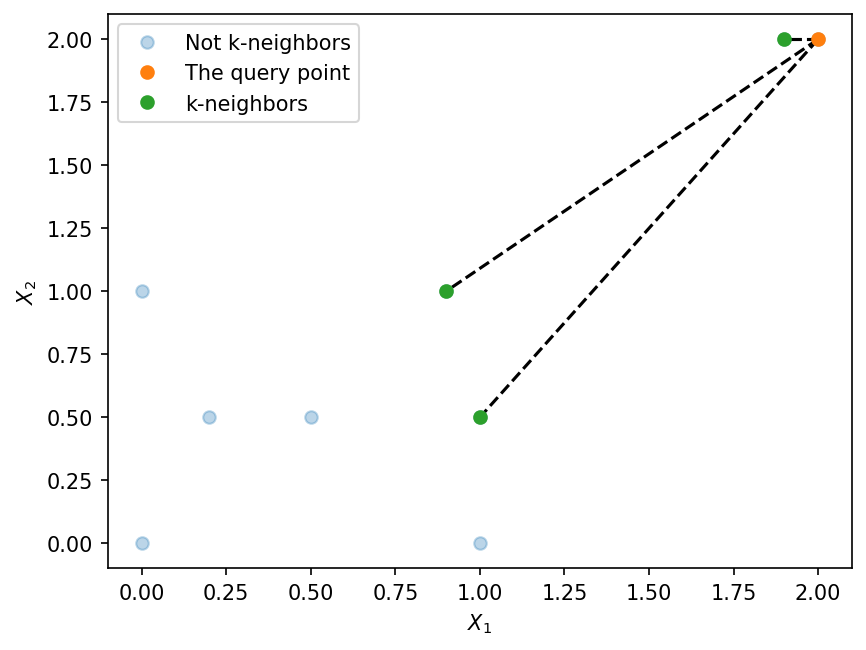

In [8]:
plot_point_and_k_neighbors(X2, 7, n_neighbors=3)

Ми бачимо, що один із 3 найближчих сусідів дуже близько, а два інших далеко. Нам потрібен якийсь спосіб об’єднати ці 3 відстані в оду оцінку. Три широко використовувані методи:
1. Використовуйте найбільшу відстань
2. Використовуйте (арифметичне) середнє відстань
3. Використовуйте середнє гармонічне.

Ми реалізуємо найдовшу відстань, а  середню арифметичну відстань і середню гармонічну відстань виконаєте як вправи нище.

#### Використання найдовшої відстані

In [9]:
def do_nn_outlier_scores(obs, n_neighbors=1):
    """
    Дає оцінку точки як відстань від точки до її k-го найближчого сусіда.
     Більша оцінка означає більшу ймовірність викиду
    """
    nn = neighbors.NearestNeighbors(n_neighbors=n_neighbors)
    nn.fit(obs)
    dists, idx = nn.kneighbors()
    scores = dists[:,-1] # останній стовпчик матриці містить найбільші відстані до сусідів
    return scores

# Test 
do_nn_outlier_scores(X2, n_neighbors=3)

array([0.8602, 0.9   , 0.9434, 1.    , 0.6403, 0.5385, 0.5099, 1.8028,
       1.7493])

Можемо зробити виведення трохи легшим для розуміння

In [10]:
def print_ranked_scores(obs, scores):
    scores_and_obs = sorted(zip(scores, obs), key=lambda t: t[0], reverse=True) # обєднали два кортежі даних і відсортували по відстін
    print('Rank  Point\t\tScore')
    print('------------------------------')
    for index, score_ob in enumerate(scores_and_obs):
        score, point = score_ob
        print(f'{index+1:3d}.  {point}\t\t{score:6.4f}')

# Подивіться на викиди, використовуючи 3 сусідніх
print_ranked_scores(X2, do_nn_outlier_scores(X2, 3))

Rank  Point		Score
------------------------------
  1.  [2. 2.]		1.8028
  2.  [1.9 2. ]		1.7493
  3.  [0. 0.]		1.0000
  4.  [1. 0.]		0.9434
  5.  [0. 1.]		0.9000
  6.  [0.9 1. ]		0.8602
  7.  [0.5 0.5]		0.6403
  8.  [0.2 0.5]		0.5385
  9.  [1.  0.5]		0.5099


Тепер подивіться на аномалії з k=1

In [11]:
print_ranked_scores(X2, do_nn_outlier_scores(X2, 1))

Rank  Point		Score
------------------------------
  1.  [0. 1.]		0.5385
  2.  [0. 0.]		0.5385
  3.  [0.9 1. ]		0.5099
  4.  [1. 0.]		0.5000
  5.  [1.  0.5]		0.5000
  6.  [0.5 0.5]		0.3000
  7.  [0.2 0.5]		0.3000
  8.  [2. 2.]		0.1000
  9.  [1.9 2. ]		0.1000


**Зауваження:** Кількість сусідів $k$, що використовуються в kNN, різко змінює результати. Зазвичай потрібен певний досвід у цій галузі, щоб знати значення $k$ або діапазон значень для $k$, які потрібно використовувати.

# kNN у зворотному напрямку: виявлення викидів за допомогою ступеня (ODIN)

Інший варіант, заснований на відстані, називається ODIN (виявлення викидів за допомогою ступеня), використовує тих самих сусідів іншим способом. Як обговорювалося в лекції, цей алгоритм ставить запитання «чи я є найближчим сусідом?». Отже, точка, яка служить Найблищим сусідом для багатьох інших – з великою кількістю зв'язків на графіку найблищих сусідів – має *низьку* оцінку аномалії. Точки з невеликим ступенем (= # вхідних посилань), швидше за все, будуть аномаліями.

Ось реалізація ODIN. Зауважте, що ми перетворюємо оцінки довільного ступеня (низького для аномалії) на шкалу від нуля до одного, де вищі значення є більшою аномалією.

In [12]:
def do_odin_outlier_scores(obs, n_neighbors=3):
    nn = neighbors.NearestNeighbors(n_neighbors=n_neighbors).fit(obs)
    graph = nn.kneighbors_graph() #Обчисліть (зважений) графік k-сусідів для точок у X, де A[i, j] присвоєно вагу ребра, яке з’єднує i з j. Матриця має формат CSR.
    indegree = graph.sum(axis=0)  # sparse matrix сумування по стовпцях

    # менший ступінь означає більшу аномалію
     # просте перетворення в [0,1], тож більша оцінка є більшою аномалією
    scores = (indegree.max() - indegree) / indegree.max()
    return np.array(scores)[0]  # convert to array

Оцініть і проранжуйте точки для набору даних X2 (дві сусідні аномалії).

In [13]:
scores_odin= do_odin_outlier_scores(X2)

In [14]:
print_ranked_scores(X2, scores_odin)

Rank  Point		Score
------------------------------
  1.  [0. 1.]		0.8333
  2.  [0. 0.]		0.8333
  3.  [2. 2.]		0.8333
  4.  [1.9 2. ]		0.8333
  5.  [1. 0.]		0.6667
  6.  [0.9 1. ]		0.1667
  7.  [0.2 0.5]		0.1667
  8.  [1.  0.5]		0.1667
  9.  [0.5 0.5]		0.0000


Дві аномалії (2, 2) і (1,9, 2) мають високі оцінки, але також точки (0, 1) і (0, 1). Крім того, результат відрізняється від того, який ми знайшли з результатами k-середніх. Як ми обговорювали на лекції, метод, який ви використовуєте, має значення.

# Розділ 2: Кластерний метод (k-середні)

 Кластеризація за допомогою k-середніх може бути використана як метод виявлення аномалій:

   1. генерація кластерів,
   2. знаходження кластера (кожна точка відноситься до свого кластеру),
   3. використовуючи відстань від точки до центру його кластера як оцінку.
  
Ці етапи доступні за допомогою `cluster.KMeans`, який після підгонки та прогнозування для отримання кластерів — як розташування кластерів, так і того, до якого кластера належить точка — надає атрибут `cluster_centers_`. Тоді ми можемо використовувати `numpy.linalg.norm` numpy (часто імпортований як `import numpy.linalg as nla`) для обчислення відстаней.

Ми почнемо з генерації деяких даних, потім покажемо, що таке кластери, і, нарешті, оцінимо аномалії.

### Генерація та перегляд даних

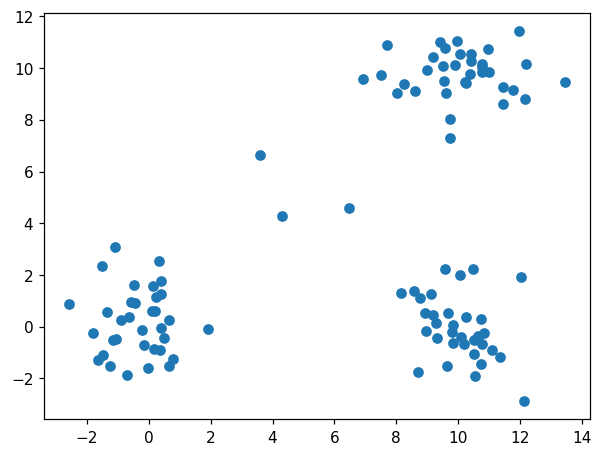

In [15]:
blobs_X, cluster_labels = sk_data.make_blobs(centers=[[0,0], [10,10], [10,0]])
anomalies, _ = sk_data.make_blobs(centers=[[5,5]], n_samples=5, cluster_std=3, random_state=42)

data = np.concatenate([blobs_X, anomalies])
cluster_labels = np.concatenate([cluster_labels, [-1]*len(anomalies)])

# Display the data before clustering
plt.figure(dpi=110)
plt.plot(data[:, 0], data[:, 1], 'o');

#### Кластеризація та показати позначення кластера

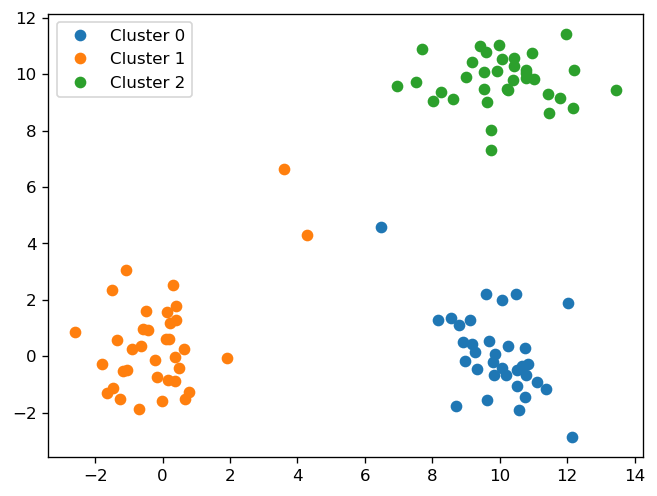

In [16]:
from sklearn.cluster import KMeans

km = KMeans(n_clusters=3).fit(data)

plt.figure(dpi=120)

for label in range(3):
    mask = (km.labels_ == label)
    plt.plot(data[mask, 0], data[mask, 1], 'o', label=f'Cluster {label}')
plt.legend();

Ви повинні запустити кластеризацію кілька разів і зауважити, що призначення деяких точок змінюється через різні початкові умови (випадковий вибір початкових центроїдів).

#### Для кожної точки знайдіть відстань від неї до її центроїда

In [17]:
centers = km.cluster_centers_[km.labels_]
# покажіть центри для перших 10 точок
centers[:10]

array([[-0.1143,  0.4754],
       [ 9.9112,  0.0995],
       [-0.1143,  0.4754],
       [10.0817,  9.7888],
       [ 9.9112,  0.0995],
       [-0.1143,  0.4754],
       [10.0817,  9.7888],
       [10.0817,  9.7888],
       [10.0817,  9.7888],
       [-0.1143,  0.4754]])

In [18]:
#Отримайте відстані до центрів і використовуйте їх як оцінки
score = np.linalg.norm(data - centers, axis=1)
score

array([2.1222, 1.1516, 1.1928, 2.5   , 2.0998, 1.454 , 1.264 , 0.7889,
       2.161 , 2.085 , 1.8032, 1.0097, 1.3809, 0.6219, 0.5451, 2.3028,
       0.4897, 3.7171, 1.0859, 2.3119, 1.8442, 1.8486, 0.254 , 1.8288,
       1.2375, 1.8607, 0.3922, 0.6722, 0.3525, 2.0875, 0.6134, 0.3007,
       2.0983, 1.567 , 1.5162, 0.825 , 2.1959, 0.315 , 1.3999, 0.8905,
       1.7839, 1.3591, 2.5031, 2.4039, 0.7423, 1.9188, 1.0744, 0.6923,
       0.8067, 1.4435, 1.6568, 0.8511, 2.5729, 0.7137, 2.0737, 0.7529,
       0.3742, 0.6389, 1.1055, 1.4542, 1.6261, 0.8737, 2.7828, 1.7446,
       1.3586, 0.9346, 0.553 , 0.8474, 0.8224, 1.1977, 2.3595, 0.0602,
       1.9446, 0.5469, 1.4249, 2.1944, 0.7647, 0.8513, 2.3268, 0.7932,
       0.9471, 1.1397, 0.798 , 1.0762, 1.9378, 1.2975, 2.2291, 0.4279,
       1.3081, 0.9685, 3.3991, 0.6129, 2.6227, 2.7661, 2.1497, 0.3222,
       0.6038, 2.1178, 0.7535, 1.1137, 5.8372, 3.1463, 7.1822, 5.6414,
       2.5102])

Які 5 точок мають найвищі оцінки? Назвемо це аномаліями

In [19]:
np.argsort(score)[::-1][:5]

array([102, 100, 103,  17,  90], dtype=int64)

Покажіть ці результати на графіку (5 точок), який включає центри кластерів (позначені «x»)

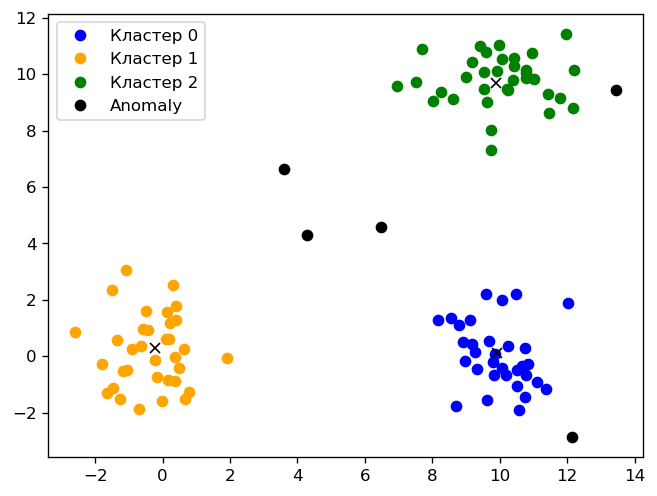

In [20]:
from sklearn.cluster import KMeans

km = KMeans(n_clusters=3).fit(data)

anomaly_idx = np.argsort(score)[::-1][:5]
anomaly_mask = np.zeros(len(data))
anomaly_mask[anomaly_idx] = 1

plt.figure(dpi=120)
colors = ['blue', 'orange', 'green']

for label, color in enumerate(colors):
    mask = (km.labels_ == label) & (anomaly_mask == 0)
    plt.plot(data[mask, 0], data[mask, 1], marker='o', linestyle='none',
             color=color, label=f'Кластер {label}')
    plt.plot(*km.cluster_centers_[label], marker='x', color='k')

plt.plot(data[anomaly_idx, 0], data[anomaly_idx, 1], marker='o', linestyle='none',
         color='k', label='Anomaly')
plt.legend();

Якщо ви повторно запустите кластеризацію достатньо разів, ви побачите, що три центральні точки завжди позначені як аномалії. Інші дві аномалії відрізняються залежно від того, як точки згруповані.

**Примітка**: якщо змінювати кількість кластерів, можна очікувати навіть більших змін. Нижче ми проілюструємо ефект зміни кількості кластерів від 1 до 5.

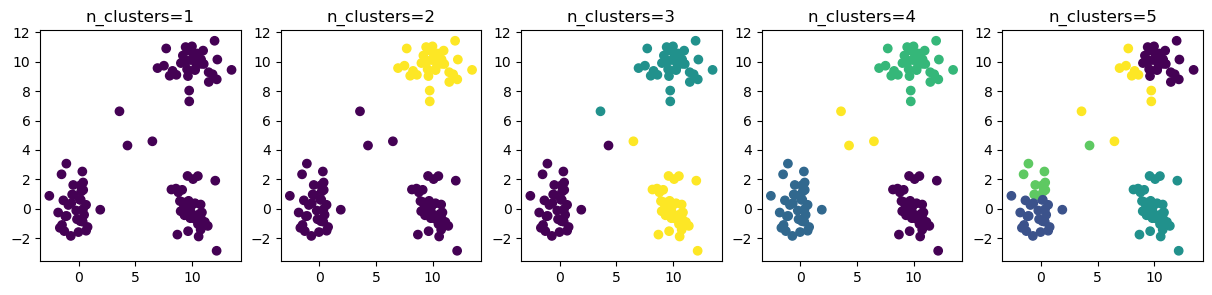

In [21]:
# Show clustering for user-specified number of clusters
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1,5, figsize=(15,3))
for ax, n_clusters in zip(axes, [1,2,3,4,5]):
    clust = KMeans(n_clusters=n_clusters)
    obs_to_clusters = clust.fit_predict(data) 
    ax.scatter(*data.T, c=obs_to_clusters)
    ax.set_title("n_clusters={}".format(n_clusters))

# Розділ 3: Методи на основі щільності (фактор локального викиду)

Фактор локального викиду (LOF) є `sklearn` має версію, доступну для використання. Зауважте, що LOF, який повертає `sklearn`, є негативним значенням, яке ми визначили в лекції.

Застосуйте LOF до набору точок ('X2'), яку ми створили в розділі 1.

In [22]:
import sklearn.neighbors as neighbors
lof = neighbors.LocalOutlierFactor(n_neighbors=3, contamination='auto')
lof.fit(X2)
sk_lof = -lof.negative_outlier_factor_
print_ranked_scores(X2, sk_lof)

Rank  Point		Score
------------------------------
  1.  [2. 2.]		1.8608
  2.  [1.9 2. ]		1.8293
  3.  [0.2 0.5]		1.2154
  4.  [1.  0.5]		1.2091
  5.  [0. 0.]		1.0333
  6.  [0. 1.]		1.0120
  7.  [1. 0.]		0.9554
  8.  [0.9 1. ]		0.8891
  9.  [0.5 0.5]		0.8272


Перегляньте значення як вище, так і нижче 1. Як обговорювалося в лекції, ми очікуємо, що значення, значно вище 1, є аномаліями.

Порівняйте з попередніми результатами kNN. Зверніть увагу, що ми використовуємо однакове значення k (=3) для обох алгоритмів.

In [23]:
print_ranked_scores(X2, do_nn_outlier_scores(X2, 3))

Rank  Point		Score
------------------------------
  1.  [2. 2.]		1.8028
  2.  [1.9 2. ]		1.7493
  3.  [0. 0.]		1.0000
  4.  [1. 0.]		0.9434
  5.  [0. 1.]		0.9000
  6.  [0.9 1. ]		0.8602
  7.  [0.5 0.5]		0.6403
  8.  [0.2 0.5]		0.5385
  9.  [1.  0.5]		0.5099


Дві аномальні точки знайдено обома способами, але результати для інших точок відрізняються.

Для повноти ми надаємо нижче явну реалізацію LOF, яка відповідає плану, наведеному в лекції. Щоб переконатися, що наш алгоритм є розумним, ми порівнюємо результати для оцінки аномалії з результатами версії `sklearn` для cluster blobs ('data') (кластерних крапель ('даних')).

In [24]:
def lof_method(obs, n_neighbors=2):
    neigh = neighbors.NearestNeighbors(n_neighbors=2).fit(obs)
    
    #Поверніть індекси та відстані до сусідів кожної точки
    topk_dist, my_kneigh = neigh.kneighbors()
    
    # Створіть список відстаней найдальшого (k-го) сусіда
    k_dist = topk_dist[:,-1]
 
    # Відстань досяжності: максимальна справжня відстань між сусідом запиту та точкою запиту
     # і відстань до k-го найближчого сусіда запитуваного сусіда
    reach = np.maximum(topk_dist, k_dist[my_kneigh])
    
    # Local reacability density Щільність локальної доступності є зворотною величиною середньої відстані доступності
    lrd = 1.0 / np.mean(reach, axis=1)
    
    # LOF Коефіцієнт локального викиду визначається як
    # середня локальна щільність сусідів / локальна щільність точки запиту
    # average local density of neighbors / local density of query point
    lrd_ratios = lrd[my_kneigh] / lrd[:, np.newaxis]
    lof = np.mean(lrd_ratios, axis=1)
    
    return lof

In [25]:
# Choose k=2
our_lof = lof_method(data, 2)
our_lof

array([0.9755, 1.0266, 1.2408, 1.6143, 1.2088, 1.2573, 1.0719, 0.9472,
       1.7607, 0.9925, 1.0143, 1.0076, 1.0014, 0.9966, 1.0118, 0.9209,
       1.0937, 3.0854, 1.066 , 0.9925, 1.0173, 1.0527, 1.1813, 1.1577,
       1.0445, 1.1574, 0.9963, 1.0243, 1.0075, 2.9574, 1.2588, 0.9963,
       1.8721, 1.3502, 0.9863, 1.0974, 0.8962, 1.0946, 1.0496, 1.38  ,
       1.5374, 1.2573, 1.9527, 1.2452, 1.0579, 1.262 , 0.9606, 0.9467,
       1.0802, 0.861 , 2.1964, 1.3424, 1.3576, 1.1409, 1.0541, 1.0454,
       1.0744, 0.7581, 1.0073, 0.8752, 0.932 , 1.219 , 2.187 , 1.171 ,
       1.2112, 1.0536, 1.0243, 1.0672, 0.9942, 0.9548, 1.0152, 0.9498,
       1.2412, 0.9076, 0.9407, 0.932 , 0.9549, 0.8164, 1.5821, 0.8962,
       0.9549, 1.0496, 1.245 , 0.9591, 0.9192, 1.1101, 1.7482, 1.0882,
       1.9033, 1.1725, 1.8186, 1.1606, 1.3461, 1.3094, 0.8962, 1.1813,
       1.1549, 1.0612, 0.9942, 1.07  , 1.1858, 1.4926, 0.9217, 0.9217,
       1.5374])

In [26]:
lof2 = neighbors.LocalOutlierFactor(n_neighbors=2, contamination='auto')
lof2.fit(data)
sk_lof2 = -lof2.negative_outlier_factor_
print('Результат такий же, як і в sklearn?', np.allclose(our_lof, sk_lof2))

Результат такий же, як і в sklearn? True


# Розділ 4: Методи на основі щільності (DBSCAN)

In [27]:
from sklearn.cluster import DBSCAN

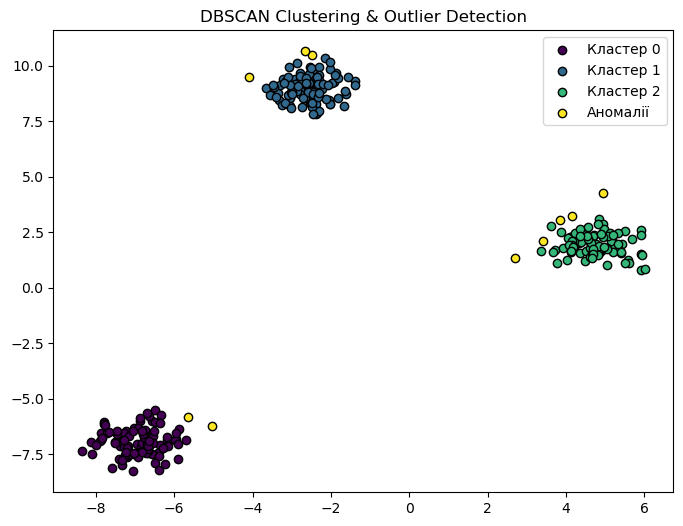

In [28]:
# Генерація тестових даних
X, _ = sk_data.make_blobs(n_samples=300, centers=3, cluster_std=0.6, random_state=42)

# Застосування DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
labels = dbscan.fit_predict(X)

# Унікальні мітки кластерів
unique_labels = set(labels)

# Визначення кольорів для кожного кластера
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_labels)))

# Побудова графіка
plt.figure(figsize=(8, 6))

for label, color in zip(unique_labels, colors):
    if label == -1:
        label_name = "Аномалії"  # Позначаємо шумові точки
    else:
        label_name = f"Кластер {label}"

    plt.scatter(X[labels == label, 0], X[labels == label, 1], 
                color=color, label=label_name, edgecolors='k')

# Додавання легенди
plt.legend()
plt.title("DBSCAN Clustering & Outlier Detection")
plt.show()

### Вправа №1

Ця вправа відноситься до дистанційних методів (розділ 1).

A. Створіть функцію `do_nn_avg_scores(obs, n_neighbors=1)`, яка обчислює оцінки викидів, використовуючи як оцінку середню арифметичну відстань від точки до кожного з найближчих сусідів `n_neighbors`.

B. Зробіть те саме, що й у частині (A), щоб створити `do_nn_harm_scores(obs, n_neighbors=1)`, де ви використовуєте середнє гармонічне замість середнього. Гармонічне середнє $n$ точок визначається як

$$\text{harmonic}(X_1, X_2, \ldots, X_n) = \frac{n}{(1/x_1) + (1/x_2) + \ldots + (1/x_n)} = \frac{\left(\prod X_i\right)^{1/n}}{\bar{X}} = \frac{(X_1X_2\cdot X_n)^{1/n}}{\bar{X}}$$

    Зауважте, що `scipy.stats` містить функцію `hmean`, яку можна використовувати.
  
Спробуйте кожну з цих функцій на нашому наборі даних $X2$.

In [29]:
def do_nn_avg_scores(obs, n_neighbors=1):
    """
    Дає оцінку точки як середню арифметичну відстань від точки до кожного з найближчих сусідів.
     Більша оцінка означає більшу ймовірність викиду
    """
    # here you code
    return scores

# Test 
do_nn_avg_scores(X2, n_neighbors=3)

[0.670148967268942,
 0.715207753966666,
 0.7168349647974027,
 0.7485410872999992,
 0.48010414124776163,
 0.4590109871423003,
 0.5033006504530929,
 1.1297941708212818,
 1.087833043608895]

In [30]:
print_ranked_scores(X2, do_nn_avg_scores(X2, 3))

Rank  Point		Score
------------------------------
  1.  [2. 2.]		1.1298
  2.  [1.9 2. ]		1.0878
  3.  [0. 0.]		0.7485
  4.  [1. 0.]		0.7168
  5.  [0. 1.]		0.7152
  6.  [0.9 1. ]		0.6701
  7.  [1.  0.5]		0.5033
  8.  [0.5 0.5]		0.4801
  9.  [0.2 0.5]		0.4590


In [31]:
from scipy.stats import hmean
def do_nn_harm_scores(obs, n_neighbors=1):
    """
    Дає оцінку точки як середню гармонічну відстань від точки до кожного з найближчих сусідів.
     Більша оцінка означає більшу ймовірність викиду
    """
    # here you code
    return scores

# Test 
do_nn_harm_scores(X2, n_neighbors=3)

[0.6402902160369849,
 0.6845754564575711,
 0.6705092145588349,
 0.7023841585291891,
 0.4350934197470957,
 0.42569856550376023,
 0.5032576411146091,
 0.267204091519258,
 0.2659864805613445]

In [32]:
print_ranked_scores(X2, do_nn_harm_scores(X2, 3))

Rank  Point		Score
------------------------------
  1.  [0. 0.]		0.7024
  2.  [0. 1.]		0.6846
  3.  [1. 0.]		0.6705
  4.  [0.9 1. ]		0.6403
  5.  [1.  0.5]		0.5033
  6.  [0.5 0.5]		0.4351
  7.  [0.2 0.5]		0.4257
  8.  [2. 2.]		0.2672
  9.  [1.9 2. ]		0.2660


Отримали суперечливі результати щодо аномальних точок

### Вправа №2

Ця вправа відноситься до кластерних методів (k-середні; Розділ 2).

Використайте вже раніше згенерований датасет (data).

A. Об’єднайте код в окремих клітинках, щоб створити функцію `do_cluster_outlier_scores(obs, n_clusters=3)`, яка обчислює викидні оцінки за допомогою кластерного методу. Переконайтеся, що ви знайшли ті самі п’ять основних аномалій, що й раніше.

B. Об’єднайте код в окремих клітинках, щоб створити функцію `plot_clusters_and_outliers(obs, n_clusters=3, n_anomalies=5)`, яка генерує діаграму, подібну до наведеної вище. Ви отримуєте ті самі результати, що й раніше?

In [33]:
def do_cluster_outlier_scores(obs, n_clusters=1):
    # here you code
    return sort_scores
do_cluster_outlier_scores(data, n_clusters=3)

array([102, 100, 103,  17,  90], dtype=int64)

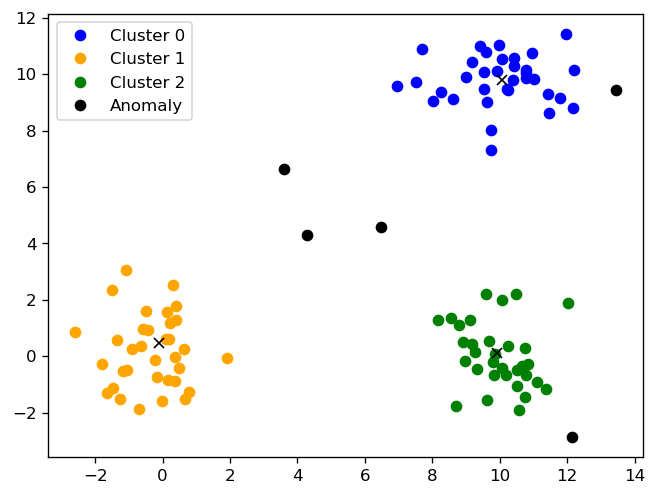

In [34]:
def plot_clusters_and_outliers(obs, n_clusters=3, n_anomalies=5):
    # here you code
    
plot_clusters_and_outliers(data, n_clusters=3, n_anomalies=5)

### Вправа №3

Ця вправа відноситься до методів на основі щільності (фактор локального викиду; Розділ 3).


A. Створіть функцію `do_lof_outlier_scores(obs, n_neighbors=3, n_anomalies=5)`, яка обчислює викидні оцінки за допомогою методу LOF. Пам’ятайте, що значення, які повертає реалізація sklearn, є негативними від того, що ми хочемо.

B. Застосуйте свою функцію до нашого набору даних $X2$, щоб отримати п’ять найбільших аномалій.

C. Наскільки метод LOF чутливий до `n_neighbors`? Спробуйте змінити `n_neighbor` (k=3,  k=2 ) на наборі даних `data`.

In [35]:
def do_lof_outlier_scores(obs, n_neighbors=3, n_anomalies=5):
    # here you code

    return sk_lof[anomaly_idx1], anomaly_idx1

In [36]:
do_lof_outlier_scores(X2, n_neighbors=3,n_anomalies=5)

(array([1.8608, 1.8293, 1.2154, 1.2091, 1.0333]),
 array([7, 8, 5, 6, 3], dtype=int64))

Оцінки вищі 1 можна вважати аномаліями при к=3:

In [37]:
print_ranked_scores(data, do_lof_outlier_scores(data, n_neighbors=3)[0])

Rank  Point		Score
------------------------------
  1.  [ 0.6537 -1.503 ]		2.6127
  2.  [10.7681 -0.6698]		2.5756
  3.  [-0.4809  1.6105]		2.5176
  4.  [11.9688 11.4286]		2.3977
  5.  [10.5637 -1.8963]		2.2946


Оцінки вищі 1 можна вважати аномаліями при к=2:

In [38]:
print_ranked_scores(data, do_lof_outlier_scores(data, n_neighbors=2)[0])

Rank  Point		Score
------------------------------
  1.  [ 0.6537 -1.503 ]		3.0854
  2.  [10.7681 -0.6698]		2.9574
  3.  [-0.4809  1.6105]		2.1964
  4.  [11.9688 11.4286]		2.1870
  5.  [10.5637 -1.8963]		1.9527


Перші 5 аномальних точок співпали і при к=2, і при к=3:

In [40]:
print_ranked_scores(data, do_lof_outlier_scores(data, n_neighbors=3)[0])

Rank  Point		Score
------------------------------
  1.  [ 0.6537 -1.503 ]		2.6127
  2.  [10.7681 -0.6698]		2.5756
  3.  [-0.4809  1.6105]		2.5176
  4.  [11.9688 11.4286]		2.3977
  5.  [10.5637 -1.8963]		2.2946


### Вправа №4

Ця вправа відноситься до методів на основі щільності (DBSCAN; Розділ 4).

Використайте вже раніше згенерований датасет (data).

Застосуйте DBSCAN для виявлення аномалій. При цьому спробуйте змінювати параметри eps та min_samples, щоб виявити ті ж 5 аномалій або близькі до них. Що відбувається із кількістю кластерів?

Порівняйте отримані результати з методм вправи 2. 

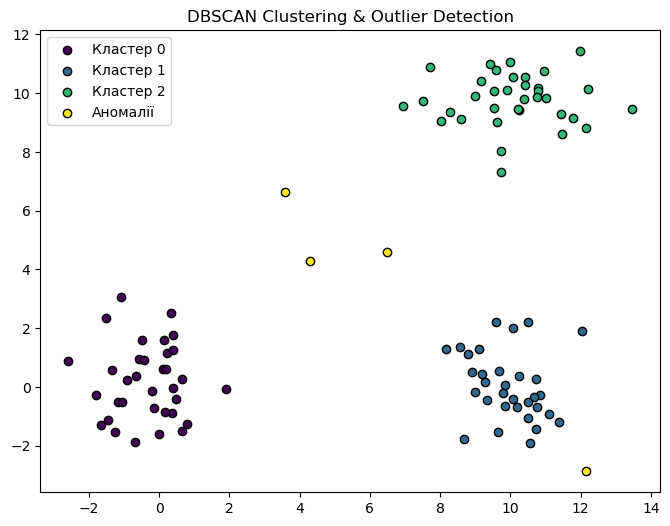

In [41]:
# Застосування DBSCAN
# here you code